In [2]:
from PIL import Image

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from keras.models import Model, load_model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, concatenate, add, Activation, Conv2DTranspose
from keras.optimizers import Adam
from keras import backend as K
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix

from keras.preprocessing.image import img_to_array, array_to_img
from keras.utils.vis_utils import plot_model

In [3]:
# Exploring a local GPU - GEFORCE GTX 1060
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [4]:
train_image_folder = r'C:\Users\Leonardo\forestfire\images5\train\images'
train_mask_folder = r'C:\Users\Leonardo\forestfire\images5\train\masks'
val_image_folder = r'C:\Users\Leonardo\forestfire\images5\val\images'
val_mask_folder = r'C:\Users\Leonardo\forestfire\images5\val\masks'

In [5]:
batch_size = 10
seed = 21
size = 384

image_datagen = ImageDataGenerator(rescale=1./255)
mask_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
train_image_generator = image_datagen.flow_from_directory(
    train_image_folder,
    batch_size = batch_size,
    target_size = (size, size),
    class_mode=None,
    color_mode='rgb',
    seed=seed
)

Found 78594 images belonging to 1 classes.


In [7]:
train_mask_generator = mask_datagen.flow_from_directory(
    train_mask_folder,
    batch_size = batch_size,
    target_size = (size, size),
    class_mode=None,
    color_mode='grayscale',
#     class_mode='binary',
    seed=seed
)

Found 78594 images belonging to 1 classes.


In [8]:
val_image_generator = image_datagen.flow_from_directory(
    val_image_folder,
    batch_size = batch_size,
    target_size = (size, size),
    class_mode=None,
    color_mode='rgb',
    seed=seed
)

Found 26700 images belonging to 1 classes.


In [9]:
val_mask_generator = mask_datagen.flow_from_directory(
    val_mask_folder,
    batch_size = batch_size,
    target_size = (size, size),
    class_mode=None,
    color_mode='grayscale',
#     class_mode='binary',
    seed=seed
)

Found 26700 images belonging to 1 classes.


In [10]:
train_generator = (pair for pair in zip(train_image_generator, train_mask_generator))

In [11]:
valid_generator= (pair for pair in zip(val_image_generator, val_mask_generator))

In [18]:
# Unet implementation

#Contraction Side    
inputs = Input(shape=(384, 384, 3))

conv1_1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='glorot_uniform', bias_initializer='zeros',
                 padding='same')(inputs)
conv1_2 = Conv2D(16, (3, 3),  activation='relu', kernel_initializer='glorot_uniform', bias_initializer='zeros',
                 padding='same')(conv1_1)
Pooling1 = MaxPooling2D(pool_size=(2, 2))(conv1_2)

conv2_1 = Conv2D(32, (3, 3), kernel_initializer='glorot_uniform', bias_initializer='zeros',
                 activation='relu',padding='same')(Pooling1)
conv2_2 = Conv2D(32, (3, 3),  kernel_initializer='glorot_uniform', bias_initializer='zeros',
                 activation='relu', padding='same')(conv2_1)
Pooling2 = MaxPooling2D(pool_size=(2, 2))(conv2_2)

conv3_1 = Conv2D(64, (3, 3), kernel_initializer='glorot_uniform', bias_initializer='zeros',
                 activation='relu', padding='same')(Pooling2)
conv3_2 = Conv2D(64, (3, 3),  kernel_initializer='glorot_uniform', bias_initializer='zeros',
                 activation='relu', padding='same')(conv3_1)
Pooling3 = MaxPooling2D(pool_size=(2, 2))(conv3_2)

conv4_1 = Conv2D(128, (3, 3), kernel_initializer='glorot_uniform', bias_initializer='zeros',
                 activation='relu', padding='same')(Pooling3)
conv4_2 = Conv2D(128, (3, 3),  kernel_initializer='glorot_uniform', bias_initializer='zeros',
                 activation='relu', padding='same')(conv4_1)
Pooling4 = MaxPooling2D(pool_size=(2, 2))(conv4_2)

conv5_1 = Conv2D(256, (3, 3), kernel_initializer='glorot_uniform', bias_initializer='zeros',
                 activation='relu', padding='same')(Pooling4)
conv5_2 = Conv2D(256, (3, 3), kernel_initializer='glorot_uniform', bias_initializer='zeros',
                 activation='relu', padding='same')(conv5_1)


#Expansion Side
Up1 = Conv2DTranspose(128, (2, 2), strides=(2, 2), kernel_initializer='glorot_uniform', bias_initializer='zeros',
                      padding='same')(conv5_2)
concat8 = concatenate([conv4_2, Up1], axis=3) 
conv6_1 = Conv2D(128, (3, 3), kernel_initializer='glorot_uniform', bias_initializer='zeros',
                 activation='relu', padding='same')(concat8)
conv6_2 = Conv2D(128, (3, 3), kernel_initializer='glorot_uniform', bias_initializer='zeros',
                 activation='relu', padding='same')(conv6_1)

Up2 = Conv2DTranspose(64, (2, 2), strides=(2, 2), kernel_initializer='glorot_uniform', bias_initializer='zeros',
                      padding='same')(conv6_2)

concat9 = concatenate([conv3_2, Up2], axis=3) 
conv7_1 = Conv2D(64, (3, 3), kernel_initializer='glorot_uniform', bias_initializer='zeros',
                 activation='relu', padding='same')(concat9)
conv7_2 = Conv2D(64, (3, 3), kernel_initializer='glorot_uniform', bias_initializer='zeros',
                 activation='relu', padding='same')(conv7_1)

Up3 = Conv2DTranspose(32, (2, 2), strides=(2, 2), kernel_initializer='glorot_uniform', bias_initializer='zeros',
                      padding='same')(conv7_2)
concat10 = concatenate([conv2_2, Up3], axis=3) 
conv8_1 = Conv2D(32, (3, 3), kernel_initializer='glorot_uniform', bias_initializer='zeros',
                 activation='relu',  padding='same')(concat10)
conv8_2 = Conv2D(32, (3, 3), kernel_initializer='glorot_uniform', bias_initializer='zeros',
                 activation='relu', padding='same')(conv8_1)

Up4 = Conv2DTranspose(16, (2, 2), strides=(2, 2), kernel_initializer='glorot_uniform', bias_initializer='zeros',
                      padding='same')(conv8_2)

concat11 = concatenate([conv1_2, Up4], axis=3) 
conv9_1 = Conv2D(16, (3, 3), kernel_initializer='glorot_uniform', bias_initializer='zeros',
                 activation='relu', padding='same')(concat11)
conv9_2 = Conv2D(16, (3, 3),  kernel_initializer='glorot_uniform', bias_initializer='zeros',
                 activation='relu', padding='same')(conv9_1)

outputs = Conv2D(filters=1, kernel_size=(3, 3), kernel_initializer='glorot_uniform', bias_initializer='zeros',
                 activation="sigmoid", padding='same')(conv9_2)

In [19]:
# other overall settings for Unet 
lr = 0.0001
epochs = 40
model = Model(inputs, outputs)
optimizer = Adam(lr = lr, decay = lr / epochs)

In [20]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 384, 384, 3)  0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 384, 384, 16) 448         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 384, 384, 16) 2320        conv2d_20[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 192, 192, 16) 0           conv2d_21[0][0]                  
__________________________________________________________________________________________________
conv2d_22 

In [21]:
# Model compilation using bynary crossentropy as loss function and accuracy as metric
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [22]:
#Defining a minimum accuracy for the model over validation and creating its respective callback
min_desired_accuracy = 0.95

class StopCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_acc') >= min_desired_accuracy): 
            print("\nReached desired accuracy, so stoping training!")
            self.model.stop_training = True

callbacks = StopCallback()

In [23]:
history = model.fit_generator(train_generator,
    steps_per_epoch=8000,  # images = batch_size * steps
    epochs=epochs,
    validation_data=valid_generator,
    validation_steps=2700,
    shuffle=True,
    verbose=True
    , callbacks=[callbacks]
)

Epoch 1/40
8000/8000 [==============================] - 3346s 418ms/step - loss: 0.1925 - acc: 0.9225 - val_loss: 0.1546 - val_acc: 0.9386
Epoch 2/40
8000/8000 [==============================] - 3008s 376ms/step - loss: 0.1488 - acc: 0.9413 - val_loss: 0.1404 - val_acc: 0.9445
Epoch 3/40
8000/8000 [==============================] - 3180s 398ms/step - loss: 0.1335 - acc: 0.9468 - val_loss: 0.1291 - val_acc: 0.9488
Epoch 4/40
8000/8000 [==============================] - 3464s 433ms/step - loss: 0.1253 - acc: 0.9497 - val_loss: 0.1245 - val_acc: 0.9504

Reached desired accuracy, so stoping training!


In [24]:
model.save('unet_v5.h5py')

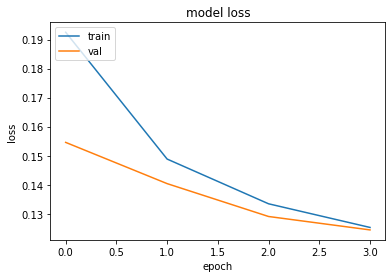

In [25]:
# plotting history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

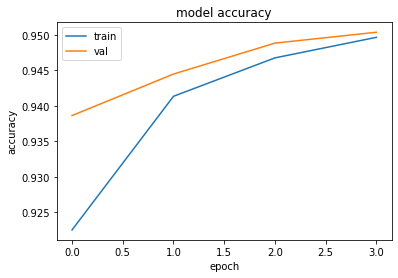

In [26]:
# plotting history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [5]:
model = load_model('C:\\Users\\Leonardo\\forestfire\\segmenation_models\\unet_v5.h5py')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [6]:
def patch_maker(full_image, patch_size=384):
    #Function receives a 1920 * 1080 image and creates the patches of 384 x 384 as a list
    patches = []
    size_0 = 1920
    size_1 = 1152
    x_pos = 0
    y_pos = 0
    img2 = full_image
    #Applies a 8 pixels border on top to have exactly 510 patches of size 64 x 64 on the 1920 x 1088 images
    temp = Image.new('RGB', (1920, (1080 + 72)), color=0)
    temp.paste(img2, (0, 36))
    
    for i in range(int(size_0 / patch_size) * int(size_1 / patch_size)):
        if x_pos == size_0:
            x_pos = 0
            y_pos += patch_size

        patches.append(temp.crop(box=(x_pos, y_pos, x_pos + patch_size, y_pos + patch_size)).copy())

        x_pos += patch_size
            
    return patches

In [7]:
def patch_unmaker(patches, patch_size=384):
    #Function receives a list of patches of size 384 x 384 and creates an 1920 x 1080 image again
    size_0 = 1920
    size_1 = 1152
    img = Image.new('RGB', (size_0, size_1), color=0)
    x_pos = 0
    y_pos = 0
    
    for i in range(len(patches)):
        if x_pos == size_0:
            x_pos = 0
            y_pos += patch_size
            img.paste(patches[i], (x_pos, y_pos))
            x_pos += patch_size
        else:
            img.paste(patches[i], (x_pos, y_pos))
            x_pos += patch_size

    
    img = img.crop(box=(0,36, size_0, (size_1 - 36)))
    
    return img

In [8]:
os.getcwd()

'C:\\Users\\Leonardo\\forestfire\\segmenation_models'

In [9]:
input_dir = r'C:\Users\Leonardo\forestfire\images5'

In [10]:
os.mkdir(os.path.join(input_dir, 'val2'))
os.mkdir(os.path.join(input_dir, 'val2\masks'))

In [10]:
val2_masks_folder = r'C:\Users\Leonardo\forestfire\images5\val2\masks'
val_folder = r'C:\Users\Leonardo\forestfire\images5\val'

In [12]:
def light_dark_selector(directory, dark_threshold, light_threshold):
    # Selects a list of images based on desired maximum light_threshold and minimum dark_threshold
    count = 0
    list_of_selected =[]
    min_intensity = 0
    file_min_intensity = ""
    max_intensity = 0
    file_max_intensity = ""

    for i in sorted(os.listdir(directory)):
        if 'original' in str(i):
            number = i.split('.')[0].split('_')[0]
            correspondent_mask = "%s_mask.png" %number
            img = Image.open(os.path.join(directory,i))
            mean_intensity = img_to_array(img).mean()
            
            if ((mean_intensity > dark_threshold) and (mean_intensity < light_threshold)):
                list_of_selected.append(i)
                list_of_selected.append(correspondent_mask)
                
                if mean_intensity >= max_intensity:
                    max_intensity = mean_intensity
                    file_max_intensity = i
                else:
                    min_intensity = mean_intensity
                    file_min_intensity = i
            else:
                pass
            
        if count % 1000 == 0:
            print(count)
        
        count += 1    
        
    print('minimal intensity was reached by %s file with %s of intensity' %(file_min_intensity, min_intensity))
    print('maximal intensity was reached by %s file with %s of intensity' %(file_max_intensity, max_intensity))
    
    return list_of_selected

In [14]:
sel_val_images = light_dark_selector(val_folder, 90,160)

0
1000
2000
3000
minimal intensity was reached by 9_original.png file with 130.73358 of intensity
maximal intensity was reached by 152_original.png file with 149.48975 of intensity


In [28]:
# Generating the masks with the model
for i in sorted(sel_val_images):
    if i == 'new':
        pass
    
    else:
        if 'original' in str(i):
            print('Reading: ', i)
            number = i.split('.')[0].split('_')[0]
            predicted_mask_name = "%s_val_msk_predicted.png" %number
            img_read = Image.open(os.path.join(val_folder, i))
            patches = patch_maker(img_read)
            y_patches = np.array(list(map(lambda img: img_to_array(img, dtype='float16'), patches)), dtype='float16') / 255
            y_patches_pred = model.predict(y_patches, batch_size=10)
            y_patches_pred[y_patches_pred>0.5] = 1
            y_patches_pred[y_patches_pred<=0.5] = 0
            y_patches_pred_all = list(map(lambda img: array_to_img(img, scale=255), y_patches_pred))
            pred_mask = patch_unmaker(y_patches_pred_all)
            pred_mask.save(os.path.join(val2_masks_folder, predicted_mask_name))
            print('Saving: ', predicted_mask_name)

Reading:  0_original.png
Saving:  0_val_msk_predicted.png
Reading:  1000_original.png
Saving:  1000_val_msk_predicted.png
Reading:  1001_original.png
Saving:  1001_val_msk_predicted.png
Reading:  1002_original.png
Saving:  1002_val_msk_predicted.png
Reading:  1003_original.png
Saving:  1003_val_msk_predicted.png
Reading:  1004_original.png
Saving:  1004_val_msk_predicted.png
Reading:  1005_original.png
Saving:  1005_val_msk_predicted.png
Reading:  1006_original.png
Saving:  1006_val_msk_predicted.png
Reading:  1007_original.png
Saving:  1007_val_msk_predicted.png
Reading:  1008_original.png
Saving:  1008_val_msk_predicted.png
Reading:  1009_original.png
Saving:  1009_val_msk_predicted.png
Reading:  100_original.png
Saving:  100_val_msk_predicted.png
Reading:  1010_original.png
Saving:  1010_val_msk_predicted.png
Reading:  1011_original.png
Saving:  1011_val_msk_predicted.png
Reading:  1012_original.png
Saving:  1012_val_msk_predicted.png
Reading:  1013_original.png
Saving:  1013_val_ms

Saving:  112_val_msk_predicted.png
Reading:  1130_original.png
Saving:  1130_val_msk_predicted.png
Reading:  1131_original.png
Saving:  1131_val_msk_predicted.png
Reading:  1132_original.png
Saving:  1132_val_msk_predicted.png
Reading:  1135_original.png
Saving:  1135_val_msk_predicted.png
Reading:  1136_original.png
Saving:  1136_val_msk_predicted.png
Reading:  1137_original.png
Saving:  1137_val_msk_predicted.png
Reading:  1138_original.png
Saving:  1138_val_msk_predicted.png
Reading:  1139_original.png
Saving:  1139_val_msk_predicted.png
Reading:  1141_original.png
Saving:  1141_val_msk_predicted.png
Reading:  1142_original.png
Saving:  1142_val_msk_predicted.png
Reading:  1144_original.png
Saving:  1144_val_msk_predicted.png
Reading:  1145_original.png
Saving:  1145_val_msk_predicted.png
Reading:  1146_original.png
Saving:  1146_val_msk_predicted.png
Reading:  1147_original.png
Saving:  1147_val_msk_predicted.png
Reading:  1148_original.png
Saving:  1148_val_msk_predicted.png
Readi

Saving:  1261_val_msk_predicted.png
Reading:  1262_original.png
Saving:  1262_val_msk_predicted.png
Reading:  1263_original.png
Saving:  1263_val_msk_predicted.png
Reading:  1264_original.png
Saving:  1264_val_msk_predicted.png
Reading:  1265_original.png
Saving:  1265_val_msk_predicted.png
Reading:  1266_original.png
Saving:  1266_val_msk_predicted.png
Reading:  1267_original.png
Saving:  1267_val_msk_predicted.png
Reading:  1268_original.png
Saving:  1268_val_msk_predicted.png
Reading:  1269_original.png
Saving:  1269_val_msk_predicted.png
Reading:  126_original.png
Saving:  126_val_msk_predicted.png
Reading:  1270_original.png
Saving:  1270_val_msk_predicted.png
Reading:  1271_original.png
Saving:  1271_val_msk_predicted.png
Reading:  1272_original.png
Saving:  1272_val_msk_predicted.png
Reading:  1273_original.png
Saving:  1273_val_msk_predicted.png
Reading:  1274_original.png
Saving:  1274_val_msk_predicted.png
Reading:  1276_original.png
Saving:  1276_val_msk_predicted.png
Readin

Saving:  1389_val_msk_predicted.png
Reading:  138_original.png
Saving:  138_val_msk_predicted.png
Reading:  1391_original.png
Saving:  1391_val_msk_predicted.png
Reading:  1392_original.png
Saving:  1392_val_msk_predicted.png
Reading:  1393_original.png
Saving:  1393_val_msk_predicted.png
Reading:  1394_original.png
Saving:  1394_val_msk_predicted.png
Reading:  1395_original.png
Saving:  1395_val_msk_predicted.png
Reading:  1396_original.png
Saving:  1396_val_msk_predicted.png
Reading:  1397_original.png
Saving:  1397_val_msk_predicted.png
Reading:  1398_original.png
Saving:  1398_val_msk_predicted.png
Reading:  1399_original.png
Saving:  1399_val_msk_predicted.png
Reading:  139_original.png
Saving:  139_val_msk_predicted.png
Reading:  13_original.png
Saving:  13_val_msk_predicted.png
Reading:  1400_original.png
Saving:  1400_val_msk_predicted.png
Reading:  1401_original.png
Saving:  1401_val_msk_predicted.png
Reading:  1403_original.png
Saving:  1403_val_msk_predicted.png
Reading:  14

Saving:  1516_val_msk_predicted.png
Reading:  1518_original.png
Saving:  1518_val_msk_predicted.png
Reading:  1519_original.png
Saving:  1519_val_msk_predicted.png
Reading:  151_original.png
Saving:  151_val_msk_predicted.png
Reading:  1520_original.png
Saving:  1520_val_msk_predicted.png
Reading:  1521_original.png
Saving:  1521_val_msk_predicted.png
Reading:  1522_original.png
Saving:  1522_val_msk_predicted.png
Reading:  1523_original.png
Saving:  1523_val_msk_predicted.png
Reading:  1525_original.png
Saving:  1525_val_msk_predicted.png
Reading:  1526_original.png
Saving:  1526_val_msk_predicted.png
Reading:  1527_original.png
Saving:  1527_val_msk_predicted.png
Reading:  1529_original.png
Saving:  1529_val_msk_predicted.png
Reading:  152_original.png
Saving:  152_val_msk_predicted.png
Reading:  1530_original.png
Saving:  1530_val_msk_predicted.png
Reading:  1531_original.png
Saving:  1531_val_msk_predicted.png
Reading:  1532_original.png
Saving:  1532_val_msk_predicted.png
Reading:

Saving:  1658_val_msk_predicted.png
Reading:  1660_original.png
Saving:  1660_val_msk_predicted.png
Reading:  1661_original.png
Saving:  1661_val_msk_predicted.png
Reading:  1662_original.png
Saving:  1662_val_msk_predicted.png
Reading:  1663_original.png
Saving:  1663_val_msk_predicted.png
Reading:  1664_original.png
Saving:  1664_val_msk_predicted.png
Reading:  1665_original.png
Saving:  1665_val_msk_predicted.png
Reading:  1666_original.png
Saving:  1666_val_msk_predicted.png
Reading:  1667_original.png
Saving:  1667_val_msk_predicted.png
Reading:  1668_original.png
Saving:  1668_val_msk_predicted.png
Reading:  1669_original.png
Saving:  1669_val_msk_predicted.png
Reading:  166_original.png
Saving:  166_val_msk_predicted.png
Reading:  1672_original.png
Saving:  1672_val_msk_predicted.png
Reading:  1673_original.png
Saving:  1673_val_msk_predicted.png
Reading:  1674_original.png
Saving:  1674_val_msk_predicted.png
Reading:  1675_original.png
Saving:  1675_val_msk_predicted.png
Readin

Saving:  249_val_msk_predicted.png
Reading:  24_original.png
Saving:  24_val_msk_predicted.png
Reading:  250_original.png
Saving:  250_val_msk_predicted.png
Reading:  251_original.png
Saving:  251_val_msk_predicted.png
Reading:  252_original.png
Saving:  252_val_msk_predicted.png
Reading:  253_original.png
Saving:  253_val_msk_predicted.png
Reading:  255_original.png
Saving:  255_val_msk_predicted.png
Reading:  256_original.png
Saving:  256_val_msk_predicted.png
Reading:  257_original.png
Saving:  257_val_msk_predicted.png
Reading:  258_original.png
Saving:  258_val_msk_predicted.png
Reading:  259_original.png
Saving:  259_val_msk_predicted.png
Reading:  25_original.png
Saving:  25_val_msk_predicted.png
Reading:  260_original.png
Saving:  260_val_msk_predicted.png
Reading:  261_original.png
Saving:  261_val_msk_predicted.png
Reading:  262_original.png
Saving:  262_val_msk_predicted.png
Reading:  263_original.png
Saving:  263_val_msk_predicted.png
Reading:  264_original.png
Saving:  264

Saving:  385_val_msk_predicted.png
Reading:  386_original.png
Saving:  386_val_msk_predicted.png
Reading:  387_original.png
Saving:  387_val_msk_predicted.png
Reading:  388_original.png
Saving:  388_val_msk_predicted.png
Reading:  389_original.png
Saving:  389_val_msk_predicted.png
Reading:  38_original.png
Saving:  38_val_msk_predicted.png
Reading:  390_original.png
Saving:  390_val_msk_predicted.png
Reading:  391_original.png
Saving:  391_val_msk_predicted.png
Reading:  392_original.png
Saving:  392_val_msk_predicted.png
Reading:  393_original.png
Saving:  393_val_msk_predicted.png
Reading:  394_original.png
Saving:  394_val_msk_predicted.png
Reading:  395_original.png
Saving:  395_val_msk_predicted.png
Reading:  396_original.png
Saving:  396_val_msk_predicted.png
Reading:  398_original.png
Saving:  398_val_msk_predicted.png
Reading:  399_original.png
Saving:  399_val_msk_predicted.png
Reading:  39_original.png
Saving:  39_val_msk_predicted.png
Reading:  400_original.png
Saving:  400

Saving:  520_val_msk_predicted.png
Reading:  521_original.png
Saving:  521_val_msk_predicted.png
Reading:  522_original.png
Saving:  522_val_msk_predicted.png
Reading:  523_original.png
Saving:  523_val_msk_predicted.png
Reading:  525_original.png
Saving:  525_val_msk_predicted.png
Reading:  527_original.png
Saving:  527_val_msk_predicted.png
Reading:  528_original.png
Saving:  528_val_msk_predicted.png
Reading:  529_original.png
Saving:  529_val_msk_predicted.png
Reading:  52_original.png
Saving:  52_val_msk_predicted.png
Reading:  530_original.png
Saving:  530_val_msk_predicted.png
Reading:  531_original.png
Saving:  531_val_msk_predicted.png
Reading:  532_original.png
Saving:  532_val_msk_predicted.png
Reading:  533_original.png
Saving:  533_val_msk_predicted.png
Reading:  534_original.png
Saving:  534_val_msk_predicted.png
Reading:  535_original.png
Saving:  535_val_msk_predicted.png
Reading:  536_original.png
Saving:  536_val_msk_predicted.png
Reading:  537_original.png
Saving:  5

Saving:  65_val_msk_predicted.png
Reading:  660_original.png
Saving:  660_val_msk_predicted.png
Reading:  661_original.png
Saving:  661_val_msk_predicted.png
Reading:  663_original.png
Saving:  663_val_msk_predicted.png
Reading:  664_original.png
Saving:  664_val_msk_predicted.png
Reading:  665_original.png
Saving:  665_val_msk_predicted.png
Reading:  666_original.png
Saving:  666_val_msk_predicted.png
Reading:  668_original.png
Saving:  668_val_msk_predicted.png
Reading:  66_original.png
Saving:  66_val_msk_predicted.png
Reading:  670_original.png
Saving:  670_val_msk_predicted.png
Reading:  671_original.png
Saving:  671_val_msk_predicted.png
Reading:  672_original.png
Saving:  672_val_msk_predicted.png
Reading:  673_original.png
Saving:  673_val_msk_predicted.png
Reading:  674_original.png
Saving:  674_val_msk_predicted.png
Reading:  675_original.png
Saving:  675_val_msk_predicted.png
Reading:  677_original.png
Saving:  677_val_msk_predicted.png
Reading:  678_original.png
Saving:  67

Saving:  801_val_msk_predicted.png
Reading:  802_original.png
Saving:  802_val_msk_predicted.png
Reading:  803_original.png
Saving:  803_val_msk_predicted.png
Reading:  804_original.png
Saving:  804_val_msk_predicted.png
Reading:  805_original.png
Saving:  805_val_msk_predicted.png
Reading:  806_original.png
Saving:  806_val_msk_predicted.png
Reading:  808_original.png
Saving:  808_val_msk_predicted.png
Reading:  809_original.png
Saving:  809_val_msk_predicted.png
Reading:  80_original.png
Saving:  80_val_msk_predicted.png
Reading:  810_original.png
Saving:  810_val_msk_predicted.png
Reading:  811_original.png
Saving:  811_val_msk_predicted.png
Reading:  812_original.png
Saving:  812_val_msk_predicted.png
Reading:  814_original.png
Saving:  814_val_msk_predicted.png
Reading:  815_original.png
Saving:  815_val_msk_predicted.png
Reading:  816_original.png
Saving:  816_val_msk_predicted.png
Reading:  817_original.png
Saving:  817_val_msk_predicted.png
Reading:  818_original.png
Saving:  8

Saving:  938_val_msk_predicted.png
Reading:  939_original.png
Saving:  939_val_msk_predicted.png
Reading:  93_original.png
Saving:  93_val_msk_predicted.png
Reading:  940_original.png
Saving:  940_val_msk_predicted.png
Reading:  942_original.png
Saving:  942_val_msk_predicted.png
Reading:  943_original.png
Saving:  943_val_msk_predicted.png
Reading:  944_original.png
Saving:  944_val_msk_predicted.png
Reading:  945_original.png
Saving:  945_val_msk_predicted.png
Reading:  947_original.png
Saving:  947_val_msk_predicted.png
Reading:  948_original.png
Saving:  948_val_msk_predicted.png
Reading:  950_original.png
Saving:  950_val_msk_predicted.png
Reading:  951_original.png
Saving:  951_val_msk_predicted.png
Reading:  953_original.png
Saving:  953_val_msk_predicted.png
Reading:  954_original.png
Saving:  954_val_msk_predicted.png
Reading:  955_original.png
Saving:  955_val_msk_predicted.png
Reading:  956_original.png
Saving:  956_val_msk_predicted.png
Reading:  957_original.png
Saving:  9

In [14]:
# Creating the metrics to analyze model performance over validation set
predicted_mask_threshold_range = 16

thresholds =[]
f1_score = []
precision = []
recall = []
accuracy = []
falsepositive = []
falsenegative = []

mask_threshold = 1 / 100

for l in range(0, predicted_mask_threshold_range, 1):

    threshold = l / 100

    y_true = []
    y_pred = []
    print('Doing predict_threshold = ', threshold)

    for i in sorted(os.listdir(val2_masks_folder)):
        sum_up = 0
        number = i.split('.')[0].split('_')[0]
        correspondent_mask = "%s_mask.png" %number
        img = Image.open(os.path.join(val2_masks_folder, i))
        patches = patch_maker(img)

        for j in range(len(patches)):
            patch = img_to_array(patches[j]) / 255
            if np.sum(patch) > (threshold * 384 * 384):
                flag = 1
            else:
                flag = 0

            sum_up += flag

        if sum_up >= 1:
            y_pred.append(1)
        else:
            y_pred.append(0)

        mask = Image.open(os.path.join(val_folder, correspondent_mask))
        sum_up_mask = np.sum(img_to_array(mask) / 255)
        if sum_up_mask > (mask_threshold * mask.size[0] * mask.size[1]):
            y_true.append(1)
        else:
            y_true.append(0)
    print(confusion_matrix(y_true, y_pred))
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    f1 = 2 * tp / (2 * tp + fp + fn)
    prec = tp / (tp + fp)
    rec = tp / (tp + fn)
    acc = (tp + tn) / (tp + fp + fn + tn)
    fpr = fp / (fp + tn)
    fnr = fn / (fn + tp)
    thresholds.append(threshold)
    f1_score.append(f1)
    precision.append(prec)
    recall.append(rec)
    accuracy.append(acc)
    falsepositive.append(fpr)
    falsenegative.append(fnr)

Doing predict_threshold =  0.0
[[192 622]
 [  1 686]]
Doing predict_threshold =  0.01
[[371 443]
 [  6 681]]
Doing predict_threshold =  0.02
[[403 411]
 [  8 679]]
Doing predict_threshold =  0.03
[[428 386]
 [  9 678]]
Doing predict_threshold =  0.04
[[457 357]
 [ 11 676]]
Doing predict_threshold =  0.05
[[473 341]
 [ 11 676]]
Doing predict_threshold =  0.06
[[495 319]
 [ 14 673]]
Doing predict_threshold =  0.07
[[507 307]
 [ 15 672]]
Doing predict_threshold =  0.08
[[519 295]
 [ 18 669]]
Doing predict_threshold =  0.09
[[528 286]
 [ 19 668]]
Doing predict_threshold =  0.1
[[541 273]
 [ 20 667]]
Doing predict_threshold =  0.11
[[554 260]
 [ 20 667]]
Doing predict_threshold =  0.12
[[565 249]
 [ 21 666]]
Doing predict_threshold =  0.13
[[578 236]
 [ 21 666]]
Doing predict_threshold =  0.14
[[584 230]
 [ 21 666]]
Doing predict_threshold =  0.15
[[591 223]
 [ 26 661]]


In [15]:
#Preparing a dataframe with the metrics
matrix = np.asarray([thresholds,f1_score,precision, recall, accuracy, falsepositive, falsenegative], dtype=np.float32)
matrix = matrix.T
df = pd.DataFrame(matrix, columns=['thresholds', 'f1_score', 'precision', 'recall', 'accuracy', 'false_positive_rate',
                                   'false_negative_rate'])

In [16]:
df

,thresholds,f1_score,precision,recall,accuracy,false_positive_rate,false_negative_rate
0,0.00,0.687719,0.524465,0.998544,0.584943,0.764128,0.001456
1,0.01,0.752071,0.605872,0.991266,0.700866,0.544226,0.008734
2,0.02,0.764209,0.622936,0.988355,0.720853,0.504914,0.011645
3,0.03,0.774415,0.637218,0.986900,0.736842,0.474201,0.013100
4,0.04,0.786047,0.654405,0.983988,0.754830,0.438575,0.016012
5,0.05,0.793427,0.664700,0.983988,0.765490,0.418919,0.016012
6,0.06,0.801668,0.678427,0.979622,0.778148,0.391892,0.020378
7,0.07,0.806723,0.686415,0.978166,0.785476,0.377150,0.021834
8,0.08,0.810418,0.693983,0.973799,0.791472,0.362408,0.026201
9,0.09,0.814138,0.700210,0.972344,0.796802,0.351351,0.027656


In [39]:
def output_mask(input_dir, file, threshold=0.10):
    # Takes one specific image and predicts the correspondent mask considering the defined threshold
    
    number = file.split('.')[0].split('_')[0]
    thresholded_mask_name = "%s_thresholded_mask.png" %number

    img_read = Image.open(os.path.join(input_dir, file))
    patches = patch_maker(img_read)
    pred_patches = []
        
    for j in range(len(patches)):
        patch = img_to_array(patches[j]) / 255
        patch = patch.reshape((1,) + patch.shape)
        y_patches_pred = model.predict(patch)
        y_patches_pred[y_patches_pred>0.5] = 1
        y_patches_pred[y_patches_pred<=0.5] = 0

        y_patches_pred = y_patches_pred.reshape(384, 384, 1)
        
        if np.sum(y_patches_pred) > (threshold * 384 * 384):
            pred_patches.append(y_patches_pred)
        else:
            y_patches_pred = np.zeros((384, 384, 1))
            pred_patches.append(y_patches_pred)
            
    y_patches_pred_all = list(map(lambda img: array_to_img(img, scale=255), pred_patches))

    pred_mask = patch_unmaker(y_patches_pred_all)
    pred_mask.save(os.path.join(input_dir, thresholded_mask_name))